# INF554 Assessment: FCNN, Transformers and Representation Learning

In this assessment, you will delve deeper into the training of Fully-Connected Neural Networks (FCNNs) and Transformers, and explore the representations learned by the models and their efficiency.

**Important notice:**
1. You must submit a single file YOUR-NAME__your-surname.ipynb by **<span style="color:red">Monday November 3rd at 14:00 CET on Moodle</span>**.
   - Make sure to submit a couple of hours before the deadline to avoid technical difficulties causing you to miss it.
   - Late submissions will not be accepted.
2. Please note that this assessment is **to be completed individually**.
   - Detected cases of plagiarism will be reported to the university, which in serious cases can have far-reaching consequences.
   - Make sure to submit your own, original solutions. 
3. You should implement what you are asked to, where you are asked to, and only use the external libraries that are already imported.
   - You will not receive marks for importing functions you are asked to implement, unless specifically stated.
   - You should only modify the parts of the notebook marked as questions, and delimited with `## Question xx: insert your code here <...> ## End-of-code: Question xx`
   - Adding intermediate computation cells, changing the execution order, or modifying the cells producing visual outputs is prohibited.

This assessment consists of two independent parts. The first focuses on FFNs and Transformers trained to compute the modulo of integers represented as binary strings. The second focuses on pre-trained Transformers fine-tuned for a classification task on real data.

**Grading scale**

```markdown
- Part 1 [34 points]
  - Q1 [CODE]:   2 points
  - Q2 [CODE]:   5 points
  - Q3 [CODE]:   5 points
  - Q4 [THEORY]: 2 points
  - Q5 [THEORY]: 2 points
  - Q6 [THEORY]: 2 points
  - Q7 [CODE]:   4 points
  - Q8 [THEORY]: 3 points
  - Q9 [THEORY]: 3 points
  - Q10[THEORY]: 6 points
- Part 2 [16 points]
  - Q11[CODE]:   4 points
  - Q12[CODE]:   5 points
  - Q13[THEORY]: 7 points

TOTAL: 50 points (25 for theory and 25 for code)
```

## PART 0 - Setup

This notebook must be executed with **Python 3.12**, using the requirements provided with the course. If your installation is correct, you should not need to modify this part. In any case, we remind you that you are not allowed to use additional libraries as replacements for the code you are asked to implement.

In [1]:
%pip install datasets transformers tqdm accelerate


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import base64
import hashlib
import os
import gc
from collections import defaultdict
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import pyplot as plt
from datasets import load_dataset
from scipy import special as scp
from sklearn.decomposition import PCA
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
)
import accelerate

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This notebook can be executed with either CPU, CUDA GPU, or Apple MPS. The runtime is longer on CPU but should remain manageable (around 5-10 minutes max on a recent mid-range processor for the longest code block). Moreover, the qualitative observations you are asked to comment on in the theory questions are the same for any device.

**Important note:**  
If you encounter issues with your device and wish to force your code to run on the CPU only, you must:  
1. Uncomment the last line of this code block to declare the `DEVICE` variable.  
2. Replace `accelerate.Accelerator()` with `accelerate.Accelerator(device_placement=False)` in Part 2.  

You do **not** need to do this if your laptop has no compatible device, as the CPU is used by default in that case.

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

def clear_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    if torch.mps.is_available():
        torch.mps.empty_cache()

    gc.collect()

# Uncomment to force CPU-only
# DEVICE = torch.device("cpu")

#### Utils

In [4]:
def safe_hash(sample: str, len=3) -> str:
    return base64.urlsafe_b64encode(hashlib.md5(sample.encode("utf-8")).digest()).decode()[:len]

## PART 1: FCNNs and Transformers learning modulo division on binary strings

In this part, we will train two model architectures: Fully Connected Neural Networks and Transformers. Our models will be trained to compute the modulo of integers represented as binary strings. The strings will have a fixed length of 20 bits. The number used as the modulus for the computations is called the BASE. For a fixed value of BASE, the problem becomes a classification task with BASE possible labels.

For example, if we compute modulo BASE=2, labels are integers in $[0,1]$:

$$00000000000000000101 \rightarrow  1 \quad [5\%2=1]$$
$$00000000000000101010 \rightarrow  0 \quad [42\%2=0]$$
$$01110000110110000011 \rightarrow  1 \quad [462211\%2=1]$$

For example, if we compute modulo BASE=3, labels are integers in $[0,2]$:

$$00000000000000000101 \rightarrow  2 \quad [5\%3=2]$$
$$00000000000000101010 \rightarrow  0 \quad [42\%3=0]$$
$$01110000110110000011 \rightarrow  1 \quad [462211\%3=1]$$

For example, if we compute modulo BASE=128, labels are integers in $[0,127]$:

$$00000000000000000101 \rightarrow  5 \quad [5\%128=5]$$
$$00000000000000101010 \rightarrow  42 \quad [42\%128=42]$$
$$01110000110110000011 \rightarrow  3 \quad [462211\%128=3]$$

### 1-A: Dataset

Our task is extremely simple from an arithmetical point of view. Consequently, we can easily generate synthetic data. **Our datasets will consist of lists of strings of length 20 containing only "0" and "1" characters.** The labels (the result of the modulo computation) can be easily computed and will be generated on the fly during training, without needing to save them in advance.

In [5]:
SEQ_LEN = 20
SEED = 42

#### [CODE] Question 1 (2 points)

Implement `get_sample_bin` and `get_sample_label` functions.


In [6]:
def get_sample_bin(sample: int) -> str:
    """
    Computes the binary representation of an integer.

    Parameters
    ----------
    sample : int
        The integer to be represented as a binary string. Must be less than 2**SEQ_LEN.

    Returns
    -------
    str
        A string of length exactly SEQ_LEN containing "0" and "1" characters, representing
        the binary representation of `sample`.
    """

    ## Question 1: insert your code here
    current = sample
    output_string = ""
    while (current >0):
        if (current%2):
            output_string = "1"+output_string
        else:
            output_string = "0"+output_string
        current = current//2

    while (len(output_string)< SEQ_LEN):
        output_string = "0"+output_string
    return output_string
    ## End-of-code: Question 1

def get_sample_label(sample: str, base: int) -> int:
    """
    Computes the label for a binary string sample given a modulus.

    Parameters
    ----------
    sample : str
        Binary string representing an integer.
    base : int
        The modulus to compute the label.

    Returns
    -------
    label : int
        The result of converting `sample` to an integer and taking modulo `base`.
    """
    ## Question 1: insert your code here

    r = len(sample)
    output = 0
    for i in range(r):
        output = output*2+int(sample[i])
    return output%base

    ## End-of-code: Question 1

In [7]:
def get_dataset(
    ds_size: int, seed: int = 42, test_prop: float = 1/8
) -> tuple[list[str], list[str]]:
    """
    Generates a synthetic dataset of binary strings and splits it into training and test sets.

    Parameters
    ----------
    ds_size : int
        The total number of samples to generate.
    seed : int, optional
        Random seed for reproducibility (default is 42).
    test_prop : float, optional
        Proportion of the dataset to use as the test set (default is 1/8).

    Returns
    -------
    train_set : list of str
        List of binary strings to be used for training.
    test_set : list of str
        List of binary strings to be used for testing.
    """
    rg = np.random.RandomState(seed)
    candidate_pool = np.array(np.arange(1 << SEQ_LEN), dtype=int)
    rg.shuffle(candidate_pool)
    selected_samples = candidate_pool[:ds_size]
    full_dataset = [get_sample_bin(sample) for sample in selected_samples]
    cut_idx = int(len(full_dataset) * (1 - test_prop))
    return full_dataset[:cut_idx], full_dataset[cut_idx:]


def get_labels(dataset: list[str], base: int) -> list[int]:
    """
    Computes the labels for a dataset of binary string samples given a modulus.

    Parameters
    ----------
    dataset : list of str
        List of binary strings representing integers.
    base : int
        The modulus to compute the labels.

    Returns
    -------
    labels : list of int
        List of integers where each element is the result of converting the corresponding
        binary string in `dataset` to an integer and taking modulo `base`.
    """
    return [get_sample_label(item, base) for item in dataset]


def batch_to_tensor(batch: list[str]) -> torch.Tensor:
    """
    Converts a batch of binary strings into a PyTorch tensor.

    Parameters
    ----------
    batch : list of str
        List of binary strings, each representing an integer.

    Returns
    -------
    result : torch.Tensor
        A tensor of shape (batch_size, SEQ_LEN), containing the binary values of the strings.
    """
    result = [[int(char) for char in s] for s in batch]
    return torch.tensor(result, dtype=torch.float32).to(DEVICE)

In [8]:
## DO NOT MODIFY
ds_train, ds_test = get_dataset(1 << 16)
print(f"Sample 0 hash: {safe_hash(ds_train[0])}")
print(f"Label 0 hash: {safe_hash(str(get_sample_label(ds_train[0], base=1024)))}")

Sample 0 hash: LN4
Label 0 hash: jvs


###  1-B : FCNN implementation and training

We will now implement Fully-Connected Neural Networks to solve the classification problem described above, and train them.

#### Utils

In [9]:
def check_model_parameter_sizes(model: torch.nn.Module) -> str:
    """
    Returns a summary of the parameters in a PyTorch model, including the number
    of parameter groups, and the total number of parameters."""
    
    param_list = list(model.parameters())
    result = f"Number of parameter groups: {len(param_list)}\n"
    result += ('-' * 55) + "\n"

    total_params = 0
    for name, param in model.named_parameters():
        result += f"{name:25} : [{param.numel():6}] {tuple(param.size())}\n"
        total_params += param.numel()

    result += f"{'TOTAL':25} : [{total_params:6}]\n"
    result += ('-' * 55) + "\n"

    return result

#### [CODE] Question 2 (5 points)

Implement the `FCNN` class below. This class allows you to instantiate fully connected neural networks (FCNNs) of various sizes. 

- The `hidden_dim` parameter refers to the hidden dimension of the *intermediate* layers. If it is `None`, there are no intermediate hidden layers, resulting in a single classification layer directly connecting the input to the output.
- The `num_layers` parameter specifies the number of layers *before* the final classification layer. For example, with `num_layers=1`, there is a first linear layer mapping the input to a hidden space, followed by a classification layer mapping the hidden space to the output. Moreover, `num_layers=0` should be equivalent to `hidden_dim=None`.

*Hint: you need to append instances of `nn.Module` subclasses in `layers` list, in the right order. These instances should correspond to the component of the model: linear layers and activation functions.*

In [10]:
class FCNN(nn.Module):
    """
    Fully Connected Neural Network (FCNN) for classification.

    Parameters
    ----------
    hidden_dim : int or None
        Dimension of the intermediate hidden layers. If None, the network
        has no hidden layers and consists of a single linear classification layer.
    base : int
        Number of output classes.
    num_layers : int, default=1
        Number of hidden layers before the final classification layer.
        Equivalent to hidden_dim=None if num_layers=0.
    """

    def __init__(self, hidden_dim: int | None, base: int, num_layers: int = 1):
        super().__init__()
        layers = []

        ## Question 2: insert your code here
        ## You should populate `layer` with the layers needed, in the right order

        if (hidden_dim is None) or (num_layers == 0):
            layers.append(nn.Linear(SEQ_LEN, base))
        else:
            # First layer: input -> hidden
            layers.append(nn.Linear(SEQ_LEN, hidden_dim))
            layers.append(nn.ReLU())
            # Additional hidden layers (hidden -> hidden)
            for _ in range(num_layers - 1):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                layers.append(nn.ReLU())
            # Final classification layer: hidden -> base
            layers.append(nn.Linear(hidden_dim, base))

        ## End-of-code: Question 2
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [11]:
## DO NOT MODIFY - you should have 19458 parameters in total
print(check_model_parameter_sizes(FCNN(hidden_dim=128, base=2, num_layers=2)))

Number of parameter groups: 6
-------------------------------------------------------
net.0.weight              : [  2560] (128, 20)
net.0.bias                : [   128] (128,)
net.2.weight              : [ 16384] (128, 128)
net.2.bias                : [   128] (128,)
net.4.weight              : [   256] (2, 128)
net.4.bias                : [     2] (2,)
TOTAL                     : [ 19458]
-------------------------------------------------------



In [12]:
## DO NOT MODIFY - you should have 63 parameters in total
print(check_model_parameter_sizes(FCNN(hidden_dim=128, base=3, num_layers=0)))

Number of parameter groups: 2
-------------------------------------------------------
net.0.weight              : [    60] (3, 20)
net.0.bias                : [     3] (3,)
TOTAL                     : [    63]
-------------------------------------------------------



### 1-C: Training loop

We will now implement the training loop and evaluate our models on our synthetic datasets.

#### [CODE] Question 3 (5 points)

Implement the `eval_model` function below.

*Hint: if your implementation is correct, the output of the next cell should be very close to 0.5 because it's evaluating the accuracy of untrained models for a binary classification task.*

In [13]:
def eval_model(
    model: nn.Module, ds_test: list[str], labels_test: list[int], batch_size: int = 256, 
) -> float:
    """
    Evaluates a classification model on a test dataset and computes accuracy.

    Parameters
    ----------
    model : nn.Module
        The PyTorch model to evaluate.
    ds_test : list of str
        List of binary string samples for testing.
    labels_test : list of int
        List of integer labels corresponding to `ds_test`.
    batch_size : int, optional
        Number of samples per batch for evaluation (default is 256).

    Returns
    -------
    accuracy : float
        Fraction of correctly classified samples in the test set.
    """
    ## Question 3: insert your code here
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, len(ds_test), batch_size):
            batch_samples = ds_test[i : i + batch_size]
            batch_labels = labels_test[i : i + batch_size]

            bits = batch_to_tensor(batch_samples)           
            outputs = model(bits).cpu()                     
            preds = outputs.argmax(dim=1)
            targets = torch.tensor(batch_labels, dtype=torch.long)

            correct += int((preds == targets).sum().item())
            total += targets.size(0)

    return correct / total
    ## End-of-code: Question 3


In [14]:
## DO NOT MODIFY
accuracies = []
_, ds_test = get_dataset(1 << 8, test_prop=1)
test_base = 2
for _ in range(1 << 10):
    model = FCNN(None, test_base).to(DEVICE)
    #print(eval_model(model, ds_test, get_labels(ds_test, test_base)))
    accuracies.append(eval_model(model, ds_test, get_labels(ds_test, test_base)))

#print(len(accuracies))
print(f"Average accuracy: {sum(accuracies) / len(accuracies)}")

Average accuracy: 0.49887847900390625


We now provide the already-implemented training loop.

In [15]:
def train_model(
    model: nn.Module,
    base: int,
    ds_train: list[str],
    ds_test: list[str],
    labels_train: list[int] | None = None,
    labels_test: list[int] | None = None,
    eval_step: int | None = None,
    batch_size: int = 256,
    silent: bool = False,
    optimizer: torch.optim.Optimizer | None = None,
) -> tuple[list[float], list[float], list[float], list[int]]:
    """
    Trains a classification model on a binary string dataset and evaluates performance.

    Parameters
    ----------
    model : nn.Module
        The PyTorch model to train.
    base : int
        The modulus used to compute labels from binary strings.
    ds_train : list of str
        Training dataset of binary strings.
    ds_test : list of str
        Test dataset of binary strings.
    labels_train : list of int, optional
        Precomputed labels for `ds_train`. If None, labels are computed on the fly.
    labels_test : list of int, optional
        Precomputed labels for `ds_test`. If None, labels are computed on the fly.
    eval_step : int, optional
        Evaluate the model every `eval_step` steps. If None, set automatically.
    batch_size : int, optional
        Number of samples per batch (default is 256).
    silent : bool, optional
        If True, disables progress printing (default is False).
    optimizer : torch.optim.Optimizer, optional
        Optimizer to use for training. If None, SGD with lr=0.01 and momentum=0.5 is used.

    Returns
    -------
    train_loss : list of float
        List of training loss values recorded at evaluation steps.
    train_acc : list of float
        List of training accuracies recorded at evaluation steps.
    test_acc : list of float
        List of test accuracies recorded at evaluation steps.
    num_samples : list of int
        Cumulative number of samples processed at each evaluation step.
    """
    if eval_step is None:
        eval_step = np.ceil(len(ds_train) // batch_size)
    if eval_step == 0:
        eval_step = 1

    model.train()
    if optimizer is None:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    # Labels?
    if labels_train is None:
        labels_train = get_labels(ds_train, base=base)
    if labels_test is None:
        labels_test = get_labels(ds_test, base=base)

    # Results
    loss_cache, acc_cache = [], []
    train_loss, train_acc, test_acc, num_samples = [], [], [], []

    # Loop
    sample_count = 0
    step = 0
    for i in tqdm(range(0, len(ds_train), batch_size), disable=silent):
        batch_samples = ds_train[i : i + batch_size]
        batch_labels = labels_train[i : i + batch_size]

        bits = batch_to_tensor(batch_samples)
        targets = torch.tensor(batch_labels, dtype=torch.long)

        optimizer.zero_grad()
        output = model(bits).cpu()
        loss = F.cross_entropy(output, targets)

        loss.backward()
        optimizer.step()

        # Caching
        loss_cache.extend([loss.item()] * bits.size(0))
        acc_cache.extend((output.argmax(dim=1) == targets).detach().cpu().int())
        sample_count += bits.size(0)

        # Evaluating?
        step += 1
        if (step % eval_step == 0) or (step - 1 == len(ds_train) // batch_size):
            train_loss.append(sum(loss_cache) / len(loss_cache))
            train_acc.append(sum(acc_cache) / len(acc_cache))
            test_acc.append(eval_model(model, ds_test, labels_test))
            num_samples.append(sample_count)
            loss_cache, acc_cache = [], []

            if not silent:
                print(
                    f"[STEP:{step:3} - SAMPLES:{sample_count:5} | Train loss {train_loss[-1]:.4f} | Train acc {train_acc[-1]:.4f} | Test acc {test_acc[-1]:.4f}"
                )

    # Output
    return train_loss, train_acc, test_acc, num_samples

### 1-D: Impact of BASE

We will now evaluate the impact of several hyperparameters on the performance of the model throughout training.

#### Utils

In [16]:
def plot_perfs_and_times(
        perfs: dict[int, tuple[list[int], list[float]]],
        times: dict[int, float],
        hpar_name: str,
        all_hpar_values: list[float],
    ) -> None:
    """
    Plot test accuracy and computation time for different hyperparameter values.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax_perf, ax_time = ax[0], ax[1]

    # Plot performance curves
    for hpar in all_hpar_values:
        ax_perf.plot(perfs[hpar][0], perfs[hpar][1], label=f"{hpar_name}={hpar}")

    ax_perf.set_xlabel("Dataset size")
    ax_perf.set_ylabel("Test accuracy")
    ax_perf.legend()
    ax_perf.set_title(f"Performance depending on {hpar_name}")

    # Plot computation times as evenly spaced bar chart
    if times is None:
        ax_time.set_axis_off()
    else:
        comp_times = [times[hpar] for hpar in all_hpar_values]

        x = range(len(all_hpar_values))  # evenly spaced positions
        ax_time.bar(x, comp_times)

        ax_time.set_xlabel(hpar_name)
        ax_time.set_ylabel("Time (s)")
        ax_time.set_title(f"Computation time depending on {hpar_name}")
        ax_time.set_xticks(x)
        ax_time.set_xticklabels(all_hpar_values)

    fig.tight_layout()
    fig.show()

Run the training loops in the next computation cell and answer:

#### [THEORY] Question 4 (2 points)

1. For which values of **BASE** does the model clearly outperform random performance? What do these values have in common?  
   - <span style="color:blue">We observe that powers of two (like 2,4,8,16,32) perform well. It is probablybecause they all depend only on the lowest log2(base) bits</span>  
2. What family of **BASE** values appears learnable within a reasonable time, and why is it expected that these are easier to learn than others?  
   - <span style="color:blue"> The bases that are powers of two and with small-factor variations are quickly learnable because in these cases, the label is a simple function that gets a fixed small subset of least significant bits, whereas in other bases, we need to find more complex properties/interactions between the other bits. (ex : for base 3, it is not necessarily simple to find out that we need to check the sum of the bits)</span>

#### [THEORY] Question 5 (2 points)
Compare the performance with 10000 samples at BASE=16 and the performance with 20000 samples at BASE=32. Explain the ratio you observed.
- <span style="color:blue"> When you double the base, you will also double the number of classes, and therefore you'll need approximately twice the data to get a similar result hence the similar performance below</span>

100%|██████████| 8/8 [00:19<00:00,  2.46s/it]


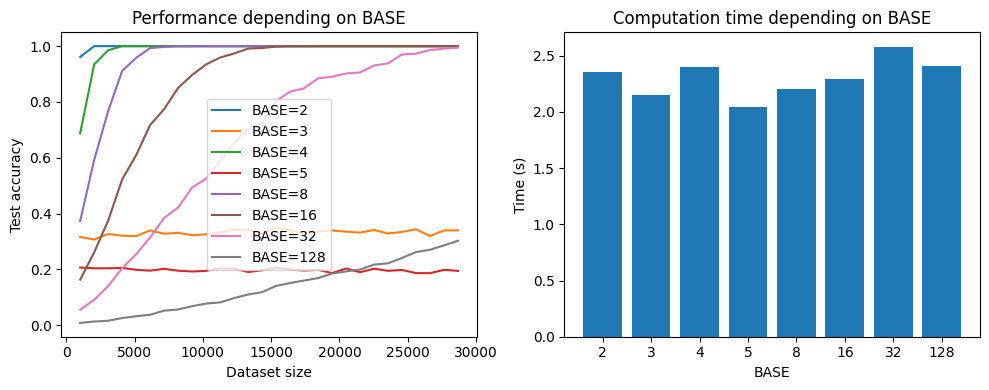

In [17]:
ALL_BASES = [2, 3, 4, 5, 8, 16, 32, 128]
DS_SIZE = 1<<15
HIDDEN_DIM = None
NUM_LAYERS = 3
BATCH_SIZE = 8

perfs = {}
times: dict[int, float] = {}

for base in tqdm(ALL_BASES):
    ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
    model = FCNN(hidden_dim=HIDDEN_DIM, base=base, num_layers=NUM_LAYERS).to(
        DEVICE
    )
    t_start = time()
    train_loss, train_acc, test_acc, num_samples = train_model(
        model,
        ds_train=ds_train,
        ds_test=ds_test,
        base=base,
        silent=True,
        batch_size=BATCH_SIZE,
        eval_step=DS_SIZE // BATCH_SIZE // 32,
    )
    t_stop = time()
    perfs[base] = (num_samples, test_acc)
    times[base] = t_stop - t_start

plot_perfs_and_times(perfs, times, "BASE", ALL_BASES)

### 1-E: Impact of the batch size

Run the training loops in the next computation cell and answer:

#### [Theory] Question 6 (2 points)

Justify why the choice of batch size involves a trade-off, and explain why this trade-off is even more salient with GPU accelerators.
- <span style="color:blue">We observe that small batches give noisy but frequent gradient updates that can improve generalization with few memory. However tih large batches, we get smoother gradients and better hardware but we have more difficulties to generalize. On GPUs the trade-off will surely be more salient bacause large batches exploit parallelism and amortize kernel overhead but are limited by device memory and amy require tuning (scheduling, LR) to avoid worse convergence</span>

100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


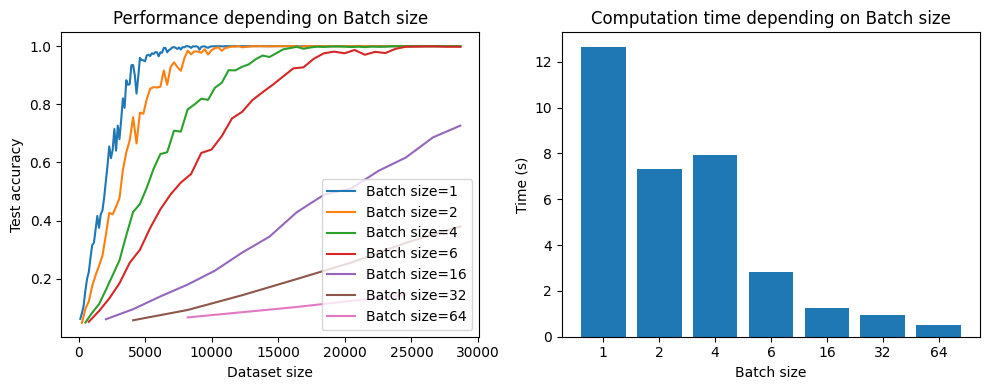

In [18]:
BASE = 32
DS_SIZE = 1<<15
HIDDEN_DIM = None
NUM_LAYERS = 3
ALL_BATCH_SIZES = [1, 2, 4, 6, 16, 32, 64]

perfs: dict[int, tuple[list[int], list[float]]] = {}
times: dict[int, float] = {}

for batch_size in tqdm(ALL_BATCH_SIZES):

    ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
    model = FCNN(hidden_dim=HIDDEN_DIM, base=BASE, num_layers=NUM_LAYERS).to(
        DEVICE
    )
    t_start = time()
    train_loss, train_acc, test_acc, num_samples = train_model(
        model,
        ds_train=ds_train,
        ds_test=ds_test,
        base=BASE,
        silent=True,
        batch_size=batch_size,
        eval_step=DS_SIZE // BATCH_SIZE // 32,
    )
    t_stop = time()
    perfs[batch_size] = (num_samples, test_acc)
    times[batch_size] = t_stop - t_start

plot_perfs_and_times(perfs, times, "Batch size", ALL_BATCH_SIZES)

We will now re-examine the trade-off involved in choosing the batch size, but in a more realistic setting. In the previous setup, the labels were "perfect" because they were defined by a deterministic mathematical rule. In real-world scenarios, however, labels are noisy and may even contradict each other. To approximate this situation, we will introduce label noise: a fraction `noise_prop` of the labels in the training set (but **not** in the test set) will be randomly replaced with values uniformly sampled from `[0, BASE-1]`.

#### [CODE] Question 7 (4 points)

Implement the new version of `get_labels`. You MUST use a `np.random.RandomState` to ensure that the injected noise is deterministic and fully replicable across runs.

In [19]:
def get_labels(dataset: list[str], base: int, noise_prop: float = 0.0) -> list[int]:
    """
    Computes labels for a dataset of binary string samples with optional label noise.

    Parameters
    ----------
    dataset : list of str
        List of binary strings representing integers.
    base : int
        The modulus to compute the labels.
    noise_prop : float, optional
        Proportion of labels in the dataset to replace with random values 
        uniformly sampled from [0, base-1]. Default is 0.0 (no noise).

    Returns
    -------
    labels : list of int
        List of integer labels corresponding to the dataset, possibly with noise injected.
    """
    ## Question 7: insert your code here
    
    random_noise = np.random.RandomState(SEED)

    labels = [get_sample_label(item, base) for item in dataset]
    if noise_prop <= 0.0:
        return labels

    n = len(labels)
    n_noisy = int(np.round(noise_prop * n))
    if n_noisy <= 0:
        return labels

    noisy_indices = random_noise.choice(n, size=min(n_noisy, n), replace=False)
    for idx in noisy_indices:
        labels[idx] = int(random_noise.randint(0, base))
    return labels

    ## End-of-code: Question 7


In [20]:
## DO NOT MODIFY
size = 1<<10
_, ds_test = get_dataset(size, seed=42, test_prop=1)
labels_no_noise = np.array(get_labels(ds_test, base=SEQ_LEN, noise_prop=0))
labels_noise_1 = np.array(get_labels(ds_test, base=SEQ_LEN, noise_prop=.05))
labels_noise_2 = np.array(get_labels(ds_test, base=SEQ_LEN, noise_prop=.05))

print(f"Approximate lower bound on noise ratio: {sum(labels_no_noise != labels_noise_1) / size:.2%}")
print(f"Replicability ratio: {sum(labels_noise_1 == labels_noise_2) / size:.2%}")

Approximate lower bound on noise ratio: 4.79%
Replicability ratio: 100.00%


Run the training loops in the next computation cell and answer:

#### [THEORY] Question 8 (3 points)

Explain why, in the presence of noisy labels, the final performance is non-monotonic with respect to the batch size (3 points, one for your explanation in each regime: low, intermediate a high batch size).
- <span style="color:blue">Low batch size: the high gradient noise helps regularization which slows convergence but helps avoid memorizing noisy labels so great perfomance !</span>
- <span style="color:blue">Middle batch size: It is a trade-off between noise and stability. Gradients are stable enought to learn the true signal with some regularization. Hence the best performance.</span>
- <span style="color:blue">Hich batch size: Gradients vary smally and there is less noise, so the model will tend to memorize the noisy labels which will harm generalization.</span>

100%|██████████| 7/7 [01:00<00:00,  8.68s/it]


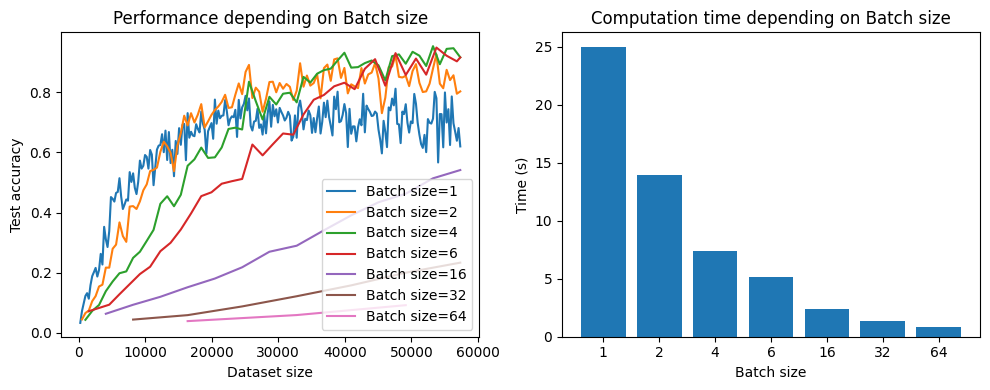

In [21]:
BASE = 32
DS_SIZE = 1<<16
HIDDEN_DIM = None
NUM_LAYERS = 3
NOISE_PROP = 0.7
ALL_BATCH_SIZES = [1, 2, 4, 6, 16, 32, 64]

perfs = {}
times = {}

for batch_size in tqdm(ALL_BATCH_SIZES):
    ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
    labels_train = get_labels(ds_train, base=BASE, noise_prop=NOISE_PROP)
    labels_test = get_labels(ds_test, base=BASE, noise_prop=0.0)
    model = FCNN(hidden_dim=HIDDEN_DIM, base=BASE, num_layers=NUM_LAYERS).to(
        DEVICE
    )
    t_start = time()
    train_loss, train_acc, test_acc, num_samples = train_model(
        model,
        ds_train=ds_train,
        ds_test=ds_test,
        base=BASE,
        labels_train=labels_train,
        labels_test=labels_test,
        silent=True,
        batch_size=batch_size,
        eval_step=DS_SIZE // BATCH_SIZE // 32,
    )
    t_stop = time()
    perfs[batch_size] = (num_samples, test_acc)
    times[batch_size] = t_stop - t_start

plot_perfs_and_times(perfs, times, "Batch size", ALL_BATCH_SIZES)


### 1-F: Introducing transformers

Running the next cells, we observe that scaling the hidden dimension is generally more effective than increasing the number of layers. However, empirically, deeper models have been shown to be effective for learning complex representations and multi-step tasks. In practice, modern LLMs include dozens of layers that progressively refine the representation of samples (see PART 2). We will now study Transformers, which are the basic building blocks of modern LLMs. We will train them on the same tasks and compare them with FCNNs.

100%|██████████| 6/6 [00:34<00:00,  5.83s/it]


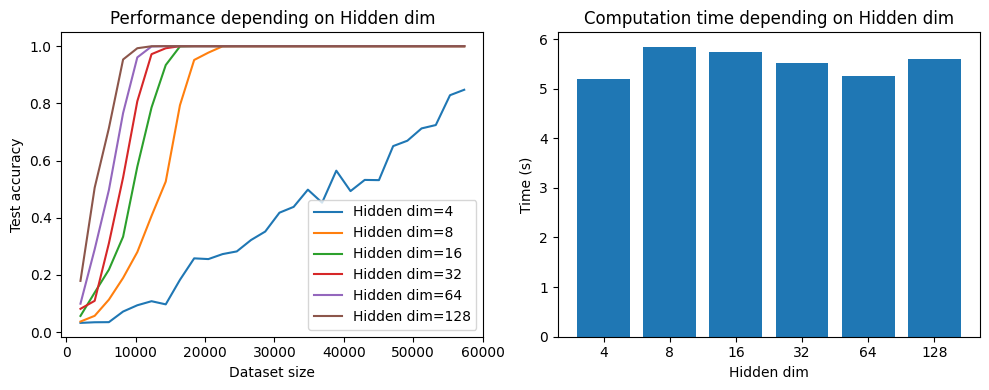

In [22]:
BASE = 32
DS_SIZE = 1<<16
ALL_HIDDEN_DIM = [4, 8, 16, 32, 64, 128]
NUM_LAYERS = 1
NOISE_PROP = 0.0
BATCH_SIZE = 8

perfs = {}
times = {}

for hiddent_dim in tqdm(ALL_HIDDEN_DIM):
        ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
        model = FCNN(hidden_dim=hiddent_dim, base=BASE, num_layers=NUM_LAYERS).to(
            DEVICE
        )
        t_start = time()
        train_loss, train_acc, test_acc, num_samples = train_model(
            model,
            ds_train=ds_train,
            ds_test=ds_test,
            base=BASE,
            silent=True,
            batch_size=BATCH_SIZE,
            eval_step=DS_SIZE // BATCH_SIZE // 32,
        )
        t_stop = time()
        perfs[hiddent_dim] = (num_samples, test_acc)
        times[hiddent_dim] = t_stop - t_start

plot_perfs_and_times(perfs, times, "Hidden dim", ALL_HIDDEN_DIM)

100%|██████████| 5/5 [00:46<00:00,  9.34s/it]


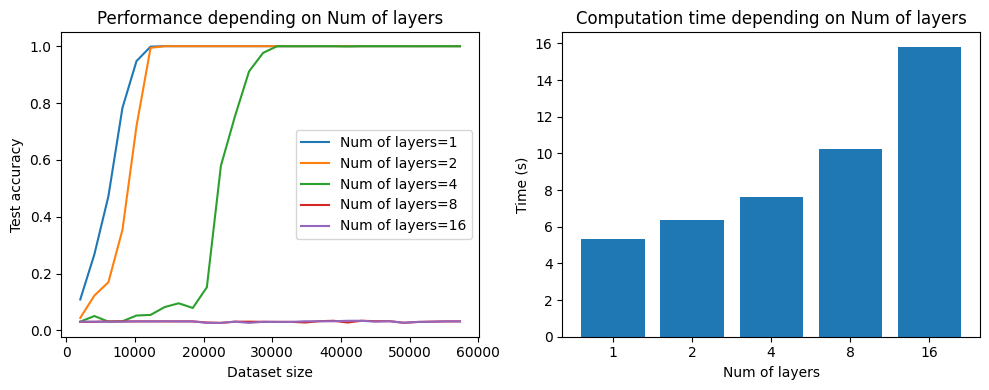

In [23]:
BASE = 32
DS_SIZE = 1<<16
HIDDEN_DIM = 64
ALL_LAYERS = [1, 2, 4, 8, 16]
NOISE_PROP = 0.0
BATCH_SIZE = 8

perfs = {}
times = {}

for layer in tqdm(ALL_LAYERS):
        ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
        model = FCNN(hidden_dim=HIDDEN_DIM, base=BASE, num_layers=layer).to(
            DEVICE
        )
        t_start = time()
        train_loss, train_acc, test_acc, num_samples = train_model(
            model,
            ds_train=ds_train,
            ds_test=ds_test,
            base=BASE,
            silent=True,
            batch_size=BATCH_SIZE,
            eval_step=DS_SIZE // BATCH_SIZE // 32,
        )
        t_stop = time()
        perfs[layer] = (num_samples, test_acc)
        times[layer] = t_stop - t_start

plot_perfs_and_times(perfs, times, "Num of layers", ALL_LAYERS)


We provide a naive implementation of Transformers, that does not include any positional encoding.

In [24]:
class ModuloTransformer(nn.Module):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        num_layers: int,
        base: int,
    ):
        super().__init__()
        self.bit_embed = nn.Embedding(2, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, base)

    def forward(self, bits: torch.Tensor) -> torch.Tensor:
        """
        bits: LongTensor of shape [batch, seq_len] with values in {0,1}
        returns: logits [batch, base]
        """
        emb = self.bit_embed(bits.long())           # [B, L, D]
        enc = self.encoder(emb)                     # [B, L, D]
        pooled = enc.mean(dim=1)                    # [B, D] (simple mean pooling)
        return self.classifier(pooled)              # [B, base]

The Transformer architecture relies on the attention formula (see the original paper [1]). Consider a sequence of $N \in \mathbb{N}$ tokens. Let $x \in \mathbb{R}^{N, d_x}$ be the stacked representation of each token before the attention module. We define three matrices which are computed from three learned parameters tensors $W_Q, W_K, W_V$: the learned queries, keys and values:

$$
Q = x W_Q \in \mathbb{R}^{N \times d_k} \\
K = x W_K \in \mathbb{R}^{N \times d_k} \\
V = x W_V \in \mathbb{R}^{N \times d_v} \\
$$

The representation of tokens at layer $l$ is updated using $y$ defined as follows:

$$
y = \text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right) V
$$

[1] A. Vasawani, N. Shazeer, N. Parmar, J. Uszkoreit et al. *Attention is all you need*. NIPS. 2017. https://arxiv.org/abs/1706.03762

#### [THEORY] Question 9 (3 points)

Let $P \in \mathbb{R}^{d_x, d_x}$ be a permutation matrix: if $\sigma: \llbracket 0, N-1 \rrbracket \mapsto \llbracket 0, N-1 \rrbracket$ is a (bijective) permutation, then $P$ contains only zeros, except ones at indices $(\sigma(k), k)$ for $k \in \llbracket 0, N-1 \rrbracket$. Then, let $x_P = Px$ be the permuted input representations.

What is the impact of this permutation of the tokens in the input string on the output of the attention mechanism as defined above? Back up your answer with a mathematical demonstration.

Do you think that the observed impact affects the performance of our implemented transformer in our task positively or negatively?
 
<span style="color:blue">

Let $x \in \mathbb{R}^{N, d_x}.$ We define $W_Q,W_K,W_V,Q,K,V,P \text{ and } x_P$ as above. \
We note $S = \frac{QK^\top}{\sqrt{d_k}}$ and $S_P = \frac{Q_P K_P^\top}{\sqrt{d_k}}$ \
\
\
Lemma : row_wise softmax commutes with permutation \
Proof : Let $\text{softmax}$ be applied row-wise i.e. : 
$$\text{softmax}(S)_{i,j} = \frac{\exp(S_{i,j})}{\sum_{k} \exp(S_{i,k})}$$
We get  
$$\text{softmax}(S_P)_{i,j} = \frac{\exp((S_P)_{i,j})}{\sum_{k} \exp((S_P)_{i,k})}$$
$$ = \frac{\exp(S_{\sigma^{-1}(i),\sigma^{-1}(j)})}{\sum_{k} \exp(S_{\sigma^{-1}(i),\sigma^{-1}(k)})} = \text{softmax}(S)_{\sigma^{-1}(i),\sigma^{-1}(j)} $$
$$ = (P\cdot \text{softmax}(S) \cdot P^T))_{i,j}$$
which prooves our lemma.\
\
\
Using this lemma, we get : 
$$\text{Attention}_P = \text{softmax}(S_P)V_P = (P\cdot \text{softmax}(S) \cdot P^T)(P V) = P\cdot \text{Attention}$$

Hence, the attention module is permutation-equivalent.\
\
\
\
The transformer without positional encodings is permutaion-equivalent and therefore can't distinguish absolute token positions which is problematic when we execute tasks where token order is important (typically modulo calculation where the position of bits are important).
</span>

#### [THEORY] Question 10 (6 points)

What is the theoreticaly optimal accuracy of the model in the training cell above? Derive it matematically. Your demonstration should produce a closed-form expression that you must implement in **one** line of Python in the dedicated spot in the next cell. Its approximate value is $0.58$. In your mathematical demonstration, denote the binomial coefficient "$k$ among $n$" as $Binom(n,k)$.

<span style="color:blue">

Let $m$ be the number of ones in length-$20$ string. The transformer without positional encoding can only observe the multiset of tokens so the associated predictor depends only on $m.$ Greedily, the optimal predictor fot that $m$ is the majority label, so the number of correct predictions for that $m$ is $$\text{max} (Binom(19,m-1), Binom(19,m)).$$
(The number of labels with least-significant-bit $1$ is $Binom(19,m-1)$ and for $0$ is $Binom(19,m)$ ).
Therefore the optimal accuracy (in base $2$) will be $$\frac{1}{2^{20}} \sum_{m = 0} ^{20} \text{max} (Binom(19,m-1), Binom(19,m))$$
$$ = \frac{1}{2^{20}} (\sum_{m = 0} ^{9} Binom(19,m) + \sum_{m = 11} ^{20} Binom(19,m-1) + Binom(19,10))$$
$$ = \frac{1}{2^{20}} (2^{19} +Binom(19,10)) = \frac{1}{2}+ \frac{Binom(19,10)}{2^{20}}$$
$$\approx 0.58$$

</span>

In [25]:
one_line_closed_form_value = one_line_closed_form_value = 0.5 + scp.comb(19, 9) / 2**20 # Question 10: Replace "0.58" with your single-line close-formed expression

print(f"Theoretical limit: {one_line_closed_form_value:.8f} [hash: {safe_hash(str(one_line_closed_form_value)[:8])}]")

Theoretical limit: 0.58809853 [hash: yzp]


In [26]:
BASE = 2
DS_SIZE = 1<<16
BATCH_SIZE = 16
ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
model = ModuloTransformer(d_model=64, nhead=4, num_layers=2, base=BASE).to(DEVICE)
train_loss, train_acc, test_acc, num_samples = train_model(
        model,
        ds_train=ds_train,
        ds_test=ds_test,
        base=BASE,
        silent=False,
        batch_size=BATCH_SIZE,
        eval_step=DS_SIZE // BATCH_SIZE // 32,
    )


  4%|▎         | 126/3584 [00:05<02:52, 20.04it/s]

[STEP:128 - SAMPLES: 2048 | Train loss 0.7003 | Train acc 0.5674 | Test acc 0.5865


  7%|▋         | 264/3584 [00:14<08:15,  6.69it/s]

[STEP:256 - SAMPLES: 4096 | Train loss 0.6827 | Train acc 0.5640 | Test acc 0.5897


 11%|█         | 390/3584 [00:19<06:41,  7.96it/s]

[STEP:384 - SAMPLES: 6144 | Train loss 0.6784 | Train acc 0.5698 | Test acc 0.5762


 14%|█▍        | 517/3584 [00:25<06:29,  7.88it/s]

[STEP:512 - SAMPLES: 8192 | Train loss 0.6649 | Train acc 0.5938 | Test acc 0.5865


 18%|█▊        | 645/3584 [00:31<06:54,  7.09it/s]

[STEP:640 - SAMPLES:10240 | Train loss 0.6790 | Train acc 0.5654 | Test acc 0.5897


 22%|██▏       | 774/3584 [00:36<05:50,  8.01it/s]

[STEP:768 - SAMPLES:12288 | Train loss 0.6750 | Train acc 0.5796 | Test acc 0.5865


 25%|██▌       | 905/3584 [00:42<05:59,  7.46it/s]

[STEP:896 - SAMPLES:14336 | Train loss 0.6661 | Train acc 0.5938 | Test acc 0.5897


 29%|██▉       | 1033/3584 [00:47<05:35,  7.59it/s]

[STEP:1024 - SAMPLES:16384 | Train loss 0.6738 | Train acc 0.5854 | Test acc 0.5897


 32%|███▏      | 1159/3584 [00:53<05:32,  7.29it/s]

[STEP:1152 - SAMPLES:18432 | Train loss 0.6721 | Train acc 0.5889 | Test acc 0.5642


 36%|███▌      | 1288/3584 [00:59<04:59,  7.67it/s]

[STEP:1280 - SAMPLES:20480 | Train loss 0.6652 | Train acc 0.6025 | Test acc 0.5865


 39%|███▉      | 1415/3584 [01:05<04:59,  7.25it/s]

[STEP:1408 - SAMPLES:22528 | Train loss 0.6706 | Train acc 0.5796 | Test acc 0.5897


 43%|████▎     | 1546/3584 [01:10<04:22,  7.77it/s]

[STEP:1536 - SAMPLES:24576 | Train loss 0.6640 | Train acc 0.6011 | Test acc 0.5865


 47%|████▋     | 1674/3584 [01:16<04:31,  7.04it/s]

[STEP:1664 - SAMPLES:26624 | Train loss 0.6760 | Train acc 0.5850 | Test acc 0.5897


 50%|█████     | 1798/3584 [01:22<04:26,  6.70it/s]

[STEP:1792 - SAMPLES:28672 | Train loss 0.6774 | Train acc 0.5718 | Test acc 0.5897


 54%|█████▎    | 1925/3584 [01:27<05:02,  5.48it/s]

[STEP:1920 - SAMPLES:30720 | Train loss 0.6670 | Train acc 0.5830 | Test acc 0.5865


 57%|█████▋    | 2056/3584 [01:33<03:28,  7.34it/s]

[STEP:2048 - SAMPLES:32768 | Train loss 0.6756 | Train acc 0.5767 | Test acc 0.5897


 61%|██████    | 2182/3584 [01:39<03:04,  7.60it/s]

[STEP:2176 - SAMPLES:34816 | Train loss 0.6675 | Train acc 0.5996 | Test acc 0.5897


 64%|██████▍   | 2311/3584 [01:45<02:50,  7.46it/s]

[STEP:2304 - SAMPLES:36864 | Train loss 0.6701 | Train acc 0.5938 | Test acc 0.5897


 68%|██████▊   | 2437/3584 [01:50<03:29,  5.48it/s]

[STEP:2432 - SAMPLES:38912 | Train loss 0.6741 | Train acc 0.5747 | Test acc 0.5897


 72%|███████▏  | 2570/3584 [01:56<02:13,  7.59it/s]

[STEP:2560 - SAMPLES:40960 | Train loss 0.6748 | Train acc 0.5811 | Test acc 0.5897


 75%|███████▌  | 2698/3584 [02:02<01:47,  8.28it/s]

[STEP:2688 - SAMPLES:43008 | Train loss 0.6749 | Train acc 0.5771 | Test acc 0.5897


 79%|███████▊  | 2822/3584 [02:07<01:37,  7.79it/s]

[STEP:2816 - SAMPLES:45056 | Train loss 0.6735 | Train acc 0.5801 | Test acc 0.5897


 82%|████████▏ | 2951/3584 [02:13<01:20,  7.87it/s]

[STEP:2944 - SAMPLES:47104 | Train loss 0.6622 | Train acc 0.6006 | Test acc 0.5865


 86%|████████▌ | 3082/3584 [02:18<01:06,  7.58it/s]

[STEP:3072 - SAMPLES:49152 | Train loss 0.6706 | Train acc 0.5972 | Test acc 0.5865


 90%|████████▉ | 3209/3584 [02:24<00:48,  7.75it/s]

[STEP:3200 - SAMPLES:51200 | Train loss 0.6707 | Train acc 0.6006 | Test acc 0.5865


 93%|█████████▎| 3336/3584 [02:29<00:32,  7.68it/s]

[STEP:3328 - SAMPLES:53248 | Train loss 0.6761 | Train acc 0.5854 | Test acc 0.5865


 97%|█████████▋| 3463/3584 [02:35<00:15,  7.60it/s]

[STEP:3456 - SAMPLES:55296 | Train loss 0.6648 | Train acc 0.5981 | Test acc 0.5865


100%|██████████| 3584/3584 [02:40<00:00, 22.28it/s]

[STEP:3584 - SAMPLES:57344 | Train loss 0.6661 | Train acc 0.5938 | Test acc 0.5865


## 1-G: Positional encoding (Pedagogical only, no questions)

To enable the model to capture the order of tokens in a sequence, we add positional encoding to the token embeddings. These encodings assign each position a unique vector that can be interpreted by the model. A common choice is the sinusoidal positional encoding, which uses sine and cosine functions at different frequencies so that relative positions can be represented without learning additional parameters.

The sinusoidal positional encoding is defined as follows. For a sequence of length $N$ and embedding dimension $d_v$:  

$$
PE_{(pos, 2i)}   = \sin\!\left(\frac{pos}{10000^{\frac{2i}{d_v}}}\right)
$$
$$
PE_{(pos, 2i+1)} = \cos\!\left(\frac{pos}{10000^{\frac{2i}{d_v}}}\right)
$$

where  
- $pos \in [0, L-1]$ is the token position,  
- $i$ is the dimension index.  

We provide an implementation below. It returns a tensor of shape $(L, d_v)$. The training in the next cells should reach perfect test accuracy.

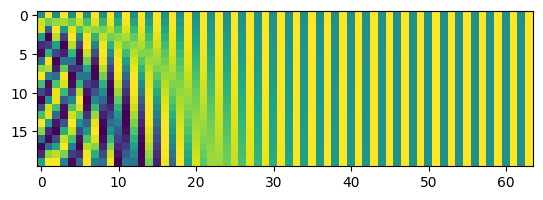

In [27]:
def sinusoidal_pe(d_model: int) -> torch.Tensor:
    """
    Compute sinusoidal positional encodings.

    Parameters
    ----------
    d_model : int
        Dimensionality of the embeddings.

    Returns
    -------
    pe : torch.Tensor of shape (SEQ_LEN, d_model)
        Positional encoding matrix, where even dimensions use sine and odd
        dimensions use cosine.
    """
    pos = torch.arange(SEQ_LEN, dtype=torch.float32).unsqueeze(1)            # Shape [L, 1]
    i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)              # Shape [1, D]
    angle_rates = 1.0 / torch.pow(10000.0, (2 * (i // 2)) / d_model)         # Shape [1, D]
    angles = pos * angle_rates                                               # Shape [L, D]
    pe = torch.zeros(SEQ_LEN, d_model)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe  # Shape [L, D]

plt.imshow(sinusoidal_pe(64))

In [28]:
class ModuloTransformerWithPE(nn.Module):
    def __init__(
        self,
        d_model: int,
        nhead: int,
        num_layers: int,
        base: int,
    ):
        super().__init__()
        self.bit_embed = nn.Embedding(2, d_model)

        # Positional encoding
        self.pe = sinusoidal_pe(d_model).unsqueeze(0).to(DEVICE) # [1, L, D]

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, base)

    def add_positional(self, x: torch.Tensor) -> torch.Tensor:
        B, L, D = x.shape
        return x + self.pe[:, :L, :]

    def forward(self, bits: torch.Tensor) -> torch.Tensor:
        """
        bits: LongTensor of shape [batch, seq_len] with values in {0,1}
        returns: logits [batch, base]
        """
        emb = self.bit_embed(bits.long())           # [B, L, D]
        emb = self.add_positional(emb)              # [B, L, D]
        enc = self.encoder(emb)                     # [B, L, D]
        pooled = enc.mean(dim=1)                    # [B, D] (simple mean pooling)
        return self.classifier(pooled)              # [B, base]
    
    


In [29]:
BASE = 32
DS_SIZE = 1<<16
BATCH_SIZE = 16
ds_train, ds_test = get_dataset(ds_size=DS_SIZE)
model = ModuloTransformerWithPE(d_model=64, nhead=4, num_layers=2, base=BASE).to(DEVICE)
train_loss, train_acc, test_acc, num_samples = train_model(
    model,
    ds_train=ds_train,
    ds_test=ds_test,
    base=BASE,
    silent=False,
    batch_size=BATCH_SIZE,
    eval_step=DS_SIZE // BATCH_SIZE // 32,
)


  4%|▎         | 126/3584 [00:05<02:38, 21.86it/s]

  4%|▎         | 134/3584 [00:09<16:41,  3.45it/s]

[STEP:128 - SAMPLES: 2048 | Train loss 3.4881 | Train acc 0.0342 | Test acc 0.0360


  7%|▋         | 265/3584 [00:15<08:13,  6.73it/s]

[STEP:256 - SAMPLES: 4096 | Train loss 3.4213 | Train acc 0.0405 | Test acc 0.0522


 11%|█         | 390/3584 [00:21<07:31,  7.08it/s]

[STEP:384 - SAMPLES: 6144 | Train loss 3.3714 | Train acc 0.0508 | Test acc 0.0686


 14%|█▍        | 519/3584 [00:27<07:11,  7.10it/s]

[STEP:512 - SAMPLES: 8192 | Train loss 3.2591 | Train acc 0.0679 | Test acc 0.0992


 18%|█▊        | 649/3584 [00:33<07:06,  6.88it/s]

[STEP:640 - SAMPLES:10240 | Train loss 2.8508 | Train acc 0.1187 | Test acc 0.1604


 22%|██▏       | 777/3584 [00:39<06:33,  7.13it/s]

[STEP:768 - SAMPLES:12288 | Train loss 2.5271 | Train acc 0.2075 | Test acc 0.2356


 25%|██▌       | 902/3584 [00:44<05:45,  7.77it/s]

[STEP:896 - SAMPLES:14336 | Train loss 1.9264 | Train acc 0.4146 | Test acc 0.5875


 29%|██▉       | 1033/3584 [00:50<05:22,  7.90it/s]

[STEP:1024 - SAMPLES:16384 | Train loss 1.2668 | Train acc 0.7466 | Test acc 0.8832


 32%|███▏      | 1159/3584 [00:55<05:01,  8.03it/s]

[STEP:1152 - SAMPLES:18432 | Train loss 0.7964 | Train acc 0.8843 | Test acc 0.9680


 36%|███▌      | 1285/3584 [01:00<06:24,  5.98it/s]

[STEP:1280 - SAMPLES:20480 | Train loss 0.5217 | Train acc 0.9341 | Test acc 1.0000


 39%|███▉      | 1415/3584 [01:06<04:50,  7.47it/s]

[STEP:1408 - SAMPLES:22528 | Train loss 0.2300 | Train acc 0.9980 | Test acc 1.0000


 43%|████▎     | 1543/3584 [01:12<04:47,  7.09it/s]

[STEP:1536 - SAMPLES:24576 | Train loss 0.1273 | Train acc 1.0000 | Test acc 1.0000


 47%|████▋     | 1674/3584 [01:18<03:51,  8.24it/s]

[STEP:1664 - SAMPLES:26624 | Train loss 0.0841 | Train acc 1.0000 | Test acc 1.0000


 50%|█████     | 1800/3584 [01:23<03:34,  8.30it/s]

[STEP:1792 - SAMPLES:28672 | Train loss 0.0614 | Train acc 1.0000 | Test acc 1.0000


 54%|█████▍    | 1928/3584 [01:28<03:19,  8.31it/s]

[STEP:1920 - SAMPLES:30720 | Train loss 0.0472 | Train acc 1.0000 | Test acc 1.0000


 57%|█████▋    | 2055/3584 [01:34<02:57,  8.60it/s]

[STEP:2048 - SAMPLES:32768 | Train loss 0.0381 | Train acc 1.0000 | Test acc 1.0000


 61%|██████    | 2184/3584 [01:39<02:49,  8.26it/s]

[STEP:2176 - SAMPLES:34816 | Train loss 0.0318 | Train acc 1.0000 | Test acc 1.0000


 64%|██████▍   | 2309/3584 [01:45<03:36,  5.90it/s]

[STEP:2304 - SAMPLES:36864 | Train loss 0.0269 | Train acc 1.0000 | Test acc 1.0000


 68%|██████▊   | 2438/3584 [01:50<02:11,  8.74it/s]

[STEP:2432 - SAMPLES:38912 | Train loss 0.0236 | Train acc 1.0000 | Test acc 1.0000


 72%|███████▏  | 2565/3584 [01:55<02:02,  8.32it/s]

[STEP:2560 - SAMPLES:40960 | Train loss 0.0208 | Train acc 1.0000 | Test acc 1.0000


 75%|███████▌  | 2694/3584 [02:00<01:45,  8.41it/s]

[STEP:2688 - SAMPLES:43008 | Train loss 0.0187 | Train acc 1.0000 | Test acc 1.0000


 79%|███████▉  | 2823/3584 [02:06<01:26,  8.80it/s]

[STEP:2816 - SAMPLES:45056 | Train loss 0.0167 | Train acc 1.0000 | Test acc 1.0000


 82%|████████▏ | 2950/3584 [02:13<02:00,  5.24it/s]

[STEP:2944 - SAMPLES:47104 | Train loss 0.0153 | Train acc 1.0000 | Test acc 1.0000


 86%|████████▌ | 3078/3584 [02:18<01:01,  8.24it/s]

[STEP:3072 - SAMPLES:49152 | Train loss 0.0139 | Train acc 1.0000 | Test acc 1.0000


 90%|████████▉ | 3209/3584 [02:23<00:48,  7.67it/s]

[STEP:3200 - SAMPLES:51200 | Train loss 0.0129 | Train acc 1.0000 | Test acc 1.0000


 93%|█████████▎| 3339/3584 [02:28<00:29,  8.39it/s]

[STEP:3328 - SAMPLES:53248 | Train loss 0.0119 | Train acc 1.0000 | Test acc 1.0000


 97%|█████████▋| 3465/3584 [02:33<00:13,  8.65it/s]

[STEP:3456 - SAMPLES:55296 | Train loss 0.0111 | Train acc 1.0000 | Test acc 1.0000


100%|██████████| 3584/3584 [02:39<00:00, 22.53it/s]

[STEP:3584 - SAMPLES:57344 | Train loss 0.0103 | Train acc 1.0000 | Test acc 1.0000


## PART 2: Real Data

In the previous part, we observed that the *representation* of integers as binary strings affected the tasks the model could perform (see your answer to Question 4). More generally, learning useful and efficient representations is crucial for models to succeed. In this part, we will explore the representations learned by real LLMs and how they support task performance.

### Dataset and model

We study Pythia models [2] fine-tuned on the AGNews dataset. This dataset consists of news snippets categorized into four classes: **0=World**, **1=Sport**, **2=Business**, and **3=Sci/Tech**. The task is to predict the class from the text snippet alone.

We fine-tuned a Pythia-160M model on this dataset using the Next Token Prediction (NTP) task. The fine-tuning script is provided in  `training_pythia.py`. We used a template to prompt the model to classify the news snippet. The latest token of each sample contains the label predicted by the model. Consequently, the logits of the penultimate token of the sequence play a similar role to the classification logits in the latest layers of the FCNNs trained in Part 1. These logits are used to compute the loss and train the model for classification. The next cells display a few dataset samples.

### Overview of the approach

This part of the assignment is loosely based on recent work in mechanistic interpretability [3]. This paper explores new methods to extracts some concepts from the internal representations of LLMs. For example, in Pythia models fine-tuned on AGNews, a sample may be classified as **World** if the hidden states represent concepts like *politics*, *war*, or *election*, or as **Sport** if they represent concepts like *goal*, *match*, or *competition*. In [3], Variational Autoencoders (VAEs) are trained to uncover directions in hidden space that correspond to such concepts, offering interpretable explanations for LLM predictions.

In this assignment, we adopt a simpler approach. Instead of training VAEs, we apply Principal Component Analysis (PCA) directly to the hidden representations. This allows us to visualize how the model represents samples from different classes across layers and training checkpoints.

- [2] S. Biderman, H. Schoelkopf, Q. Anthony, H. Bradley et al. *Pythia: A Suite for Analyzing Large Language Models Across Training and Scaling*. ArXiv preprint. 2023. https://arxiv.org/abs/2304.01373
- [3] M. Le Bail, J. Dentan, D. Buscaldi, and S. Vanier. *Unveiling Decision-Making in LLMs for Text Classification : Extraction of influential and interpretable concepts with Sparse Autoencoders.* ArXiv preprint. 2025. https://arxiv.org/abs/2506.23951


In [30]:
# To force CPU-only, replace with accelerate.Accelerator(device_placement=False)
accelerator = accelerate.Accelerator()
DATASET_NAME = "fancyzhx/ag_news"
MODEL_NAME = "EleutherAI/pythia-160m"
dataset = load_dataset(DATASET_NAME)
dataset["test"].to_pandas().head()

,text,label
0,Fears for T N pension after talks Unions repre...,2
1,The Race is On: Second Private Team Sets Launc...,3
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3
3,Prediction Unit Helps Forecast Wildfires (AP) ...,3
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,3


We provide checkpoints of models that have already been fine-tuned. The following cell creates a DataLoader, `test_dl`, which will be used to explore the representations learned by the model at different checkpoints. This DataLoader is similar to the one used during fine-tuning.

In [31]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.truncation_side="left"

def format_template(sample):
    return dict(
        text = f"What type of information is presented in this article?\n\n{sample['text']}\n\nOPTIONS:\n0: World\n1: Sport\n2 :Buisiness\n3: Sci/Tech\nANSWER:{sample['label']}",
        label=sample['label'],
    )

tokenized_ds_test = dataset["test"].map(format_template).map(lambda sample: tokenizer(sample["text"]))
tokenized_ds_test = tokenized_ds_test.select(np.random.RandomState(42).choice(len(tokenized_ds_test), size=1000, replace=False))

test_dl = accelerator.prepare(DataLoader(
    tokenized_ds_test.select_columns(["input_ids", "attention_mask", "label"]),
    collate_fn=DataCollatorForLanguageModeling(tokenizer=tokenizer,mlm=False),
    batch_size=4,
    num_workers=4,
    persistent_workers=True,
))

/home/codespace/.local/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### [CODE] Question 11 (4 points)

Implement the evaluation loop. We recall that we use Next Token Prediction task. The label must be extracted consistently with the template used for prediction, and the index of the logits should be chosen accordingly. See the introduction of Part 2 for details. The loss should be computed using `torch.nn.CrossEntropyLoss`.

In [32]:
def eval_model(model: nn.Module, eval_dl: DataLoader) -> tuple[float, float]:
    """
    Evaluate a Transformer model on a dataset loader.

    Parameters
    ----------
    model : torch.nn.Module
        The Transformer model to evaluate.
    eval_dl : DataLoader
        A PyTorch DataLoader providing batches of evaluation data, with input
        features and labels.

    Returns
    -------
    accuracy : float
        Fraction of correctly predicted labels over the dataset.
    avg_loss : float
        Mean cross-entropy loss computed on the predicted labels.
    """
    model.eval()

    correct = 0
    total = 0
    losses = []
    for batch in tqdm(eval_dl):
        outputs = model(**batch)
        outputs_logits = outputs.logits

        # Retrieving logits and labels
        ## Question 11: your code here
        idx_logits = -2   # logits at position -2 predict token at position -1
        idx_labels = -1   # labels are the last token in the sequence
        ## End-of-code: Question 11
        logits_prediction = outputs_logits[:,idx_logits].contiguous().view(-1, model.config.vocab_size)
        labels_to_pred = batch.labels[:,idx_labels].view(-1)
        
        ## Question 11: your code here
        loss_per_sample = F.cross_entropy(logits_prediction, labels_to_pred, reduction="none")
        losses.extend(loss_per_sample.detach().cpu().numpy().tolist())
        preds = logits_prediction.argmax(dim=1)
        correct += int((preds == labels_to_pred).sum().item())
        total += labels_to_pred.size(0)
        ## End-of-code: Question 11
        

    return (correct / total, np.mean(losses))


We now evaluate the five fine-tuning checkpoints that we provide: 

In [33]:
ALL_CHECKPOINTS = [50,100,200,1000,3000]
ALL_LAYERS = [1,3,5,7,9,11]
MODEL_PYTHIA="jdentan/teaching-pythia160m-AGNews-chk{checkpoint}"
os.environ["TOKENIZERS_PARALLELISM"]="0"

In [ ]:
eval_results = []
for checkpoint in ALL_CHECKPOINTS:
    clear_cache()
    current_model = AutoModelForCausalLM.from_pretrained(MODEL_PYTHIA.format(checkpoint=checkpoint)).to(DEVICE)
    eval_results.append(eval_model(current_model, test_dl))
    clear_cache()

  0%|          | 0/250 [00:00<?, ?it/s]

 86%|████████▌ | 214/250 [04:02<00:37,  1.04s/it]

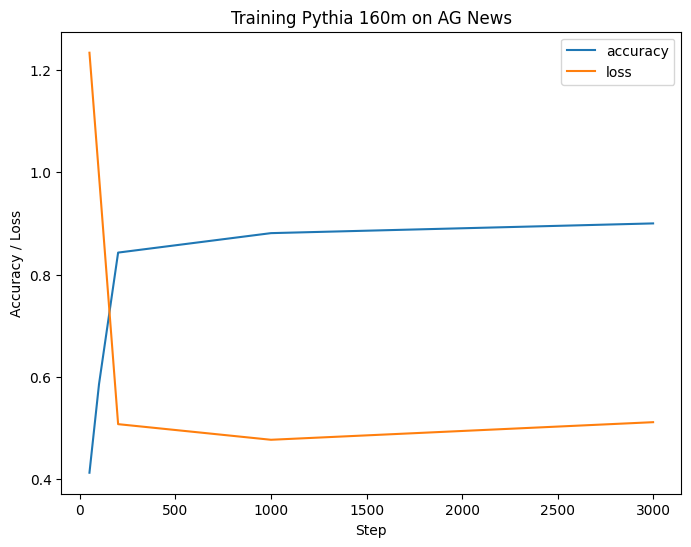

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(ALL_CHECKPOINTS, [result[0] for result in eval_results], label="accuracy")
ax.plot(ALL_CHECKPOINTS, [result[1] for result in eval_results], label="loss")
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy / Loss")
ax.set_title("Training Pythia 160m on AG News")
ax.legend()

### Representations across time and layers

We will now extract the representations learned by the models during fine-tuning.

#### [CODE] Question 12 (5 points)

Complete the implementation of the function below. The label must be extracted consistently with the template used for prediction, and the representations should be taken at the token index used to compute the logits for label prediction. See the introduction of Part 2 for details.  


Hint: using kwarg `output_hidden_states=True` in model(...) allows you to access `outputs["hidden_states"][layer]`, for each layer, which is a tensor of shape `(batch_size, sequence_length, hidden_dimension)`

In [ ]:
def get_representations(
    model: nn.Module, eval_dl: DataLoader
) -> tuple[dict[int, torch.Tensor], torch.Tensor]:
    """
    Extract hidden representations from all layers of a Transformer model.

    Parameters
    ----------
    model : torch.nn.Module
        The Transformer model from which to extract hidden states.
    eval_dl : DataLoader
        A PyTorch DataLoader providing batches of input samples and labels.

    Returns
    -------
    all_repz_tensor : dict[int, torch.Tensor]
        A dictionary mapping layer indices to tensors of shape (num_samples, hidden_dim)
        containing the hidden representations for each layer.
    all_labels_tensor : torch.Tensor
        Tensor of shape (num_samples,) containing the labels corresponding to the inputs.
    """

    ## Question 12: your code here
    model.eval()
    reps_acc: dict[int, list[torch.Tensor]] = {}
    labels_acc: list[torch.Tensor] = []
    idx_rep = -2   # token index whose representation is used for prediction (penultimate token)
    idx_label = -1 # label token index (last token)

    with torch.no_grad():
        for batch in tqdm(eval_dl):
            outputs = model(**batch, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # tuple: (embeddings, layer1, ..., layerN)

            # extract labels (works whether batch exposes .labels or is a dict)
            labels_tensor = batch.labels if hasattr(batch, "labels") else batch["labels"]
            labels_batch = labels_tensor[:, idx_label].view(-1).detach().cpu()
            labels_acc.append(labels_batch)

            # accumulate representations for each layer index
            for layer_idx, layer_h in enumerate(hidden_states):
                rep = layer_h[:, idx_rep, :].detach().cpu()  # [B, D]
                reps_acc.setdefault(layer_idx, []).append(rep)

    # concatenate per-layer lists into tensors and concatenate labels
    all_repz_tensor: dict[int, torch.Tensor] = {
        layer_idx: torch.cat(tensors, dim=0) for layer_idx, tensors in reps_acc.items()
    }
    all_labels_tensor = torch.cat(labels_acc, dim=0)

    return all_repz_tensor, all_labels_tensor
    ## End-of-code: Question 12


: 

We will now use this function to load the representations learnt by the models at the five checkpoints we provide.

In [ ]:
representations_per_checkpoint = {}
for checkpoint in ALL_CHECKPOINTS:
    clear_cache()
    current_model = AutoModelForCausalLM.from_pretrained(MODEL_PYTHIA.format(checkpoint=checkpoint)).to(DEVICE)
    representations_per_checkpoint[checkpoint] = get_representations(current_model, test_dl)
    clear_cache()

 26%|██▋       | 66/250 [01:11<03:20,  1.09s/it]

In [ ]:
n_row = len(ALL_LAYERS)
n_col = len(ALL_CHECKPOINTS)
fig, axs = plt.subplots(n_row, n_col, figsize=(4*n_col, 4*n_row))

for idx_row, layer in enumerate(sorted(ALL_LAYERS, reverse=True)):
    for idx_col, checkpoint in enumerate(ALL_CHECKPOINTS):
        ax = axs[idx_row, idx_col]

        # Fetching data
        representations = representations_per_checkpoint[checkpoint][0][layer].cpu().numpy()
        labels = representations_per_checkpoint[checkpoint][1].cpu().numpy()

        # Reduce to 2D with PCA
        pca = PCA(n_components=2)
        representations_2d = pca.fit_transform(representations)

        ax.scatter(representations_2d[:,0], representations_2d[:,1], c=labels, cmap="tab10", alpha=.7)
        ax.set_title(f"Checkpoint:{checkpoint} | Layer:{layer}")

Run the previous cell and answer:

#### [THEORY] Question 13 (7 points)

Based on the plot made by a colleague 

Comment on the plot:  

1. [2 points] What is the geometric shape underlying what we observe at **layer 11, checkpoint 3000**? What would you expect with a 3D PCA, and how can this be explained theoretically?
   - <span style="color:blue">We have four well-separated clusters whose centers lie roughly at the vertices of a low-dimensional simplex. In 3D PCA the same clusters would appear as four distinct vertices of a tetrahedron this arises because the linear classification head and training push class means apart and concentrate variance on a few task-relevant directions. </span>

2. [1 point] How does this **geometric shape** evolves at a fixed layer as training progresses? 
   - <span style="color:blue">As training proceeds, the shape evolves from diffuse clouds to more seperated clusters at a fixed layer.</span>

3. [1 points] How do the representations evolve across layers at a **fixed training step**?
   - <span style="color:blue">It depends on the layers : early layers are noisy whereas deep layers underline task-relevant directions and seperate classes.</span>

4. [3 points] Comment on how the **range of the values** shown on the axes at layer 11 evolves during training. Explain how the training process leads to this evolution.
   - <span style="color:blue">The axis ranges at layer 11 grow whil training because the model amplifies the directions that seperate classes, so most of the variances end up in the few principal components and then level off once the classifier converges.</span>